In [3]:
# new test line
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch import autograd
import time
%matplotlib inline


In [4]:
"""
用神经网络模拟微分方程,f(x)'=f(x),初始条件f(0) = 1
"""
# 定义Net class
class Net(nn.Module):
    def __init__(self, NL, NN): # NL n个l（线性，全连接）隐藏层， NN 输入数据的维数，
        # NL是有多少层隐藏层
        # NN是每层的神经元数量
        super(Net, self).__init__()
        self.input_layer = nn.Linear(1, NN)
        self.hidden_layer = nn.Linear(NN,int(NN/2)) ## 原文这里用NN，我这里用的下采样，经过实验验证，“等采样”更优。更多情况有待我实验验证。
        self.output_layer = nn.Linear(int(NN/2), 1)

    def forward(self, x):
        out = torch.tanh(self.input_layer(x))
        out = torch.tanh(self.hidden_layer(out))
        out_final = self.output_layer(out)
        #out_final = torch.relu(out_final)
        # Apply the threshold element-wise using torch.where
        out_final = torch.where(out_final < 0.001, torch.tensor(0.01), out_final)
        return out_final

In [14]:
devices = ['cuda', 'cpu']
run_device = devices[0]
print(run_device)

cuda


In [15]:
net=Net(4,20).to(run_device) # 4层 20个
mse_cost_function = torch.nn.MSELoss(reduction='mean') # Mean squared error 均方误差求
optimizer = torch.optim.Adam(net.parameters(),lr=1e-4)  # 优化器

def ode_01(x,net):
    y=net(x)
    y_x = autograd.grad(y, x,grad_outputs=torch.ones_like(net(x)),create_graph=True)[0]
    return y_x * y**(-1/2) - 2  # y-y' = 0

# requires_grad=True).unsqueeze(-1)

iterations=13000

In [16]:
start = time.perf_counter()
for epoch in range(iterations):

    optimizer.zero_grad()  # 梯度归0

    ## 求边界条件的损失函数
    x_0 = torch.zeros(2000, 1).to(run_device)
    y_0 = net(x_0)
    mse_i = mse_cost_function(y_0, torch.zeros(2000, 1).to(run_device))  # f(0) - 1 = 0

    ## 方程的损失函数
    x_in = np.random.uniform(low=0.0, high=2.0, size=(2000, 1))
    pt_x_in = autograd.Variable(torch.as_tensor(np.asarray(x_in)).float().to(run_device), requires_grad=True)  # x 随机数
    pt_y_colection=ode_01(pt_x_in,net)
    pt_all_zeros= autograd.Variable(torch.as_tensor(np.asarray(np.zeros((2000,1)))).float().to(run_device), requires_grad=False)
    mse_f=mse_cost_function(pt_y_colection, pt_all_zeros)  # y-y' = 0

    loss = mse_i + mse_f
    loss.backward()  # 反向传播
    optimizer.step()  # 优化下一步。This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

end = time.perf_counter()
print("Running time", end-start)

Running time 45.49383322600079


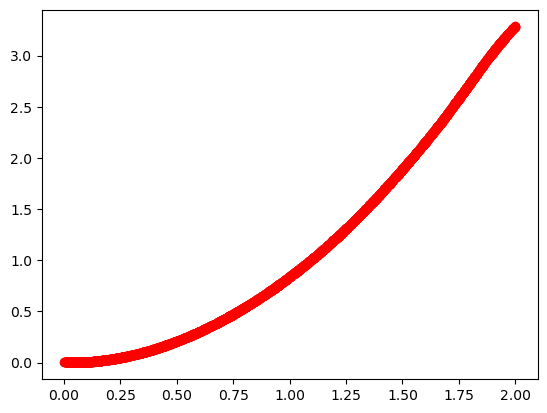

In [16]:
y = torch.sqrt(pt_x_in).to(run_device)  # y 真实值
y_train0 = net(pt_x_in) # y 预测值
plt.figure()
#plt.scatter(pt_x_in.detach().numpy(), y.detach().numpy())
plt.scatter(pt_x_in.detach().to('cpu').numpy(), y_train0.detach().to('cpu').numpy(),c='red')
plt.show()

In [17]:
x_0.device

device(type='cuda', index=0)

In [18]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 4060 Ti'

# 有闸渠1D水流模拟

## 导入相关模块

In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from matplotlib import cm
%matplotlib inline
# jupyter notebook中魔法方法

## Build the networks

In [63]:
# 模型搭建
class Net(nn.Module):
    def __init__(self, NN): #  NN 输入数据的维数， 128 256
        # NN是每层的神经元数量
        super(Net, self).__init__()

        self.input_layer = nn.Linear(2, NN)
        self.hidden_layer1 = nn.Linear(NN,NN) ## 原文这里用NN，我这里用的下采样，经过实验验证，“等采样”更优
        self.hidden_layer2 = nn.Linear(NN, NN)  ## 原文这里用NN，我这里用的下采样，经过实验验证，“等采样”更优
        self.output_layer = nn.Linear(NN, 1)

    def forward(self, x): # 一种特殊的方法 __call__() 回调
        out = torch.tanh(self.input_layer(x))
        out = torch.tanh(self.hidden_layer1(out))
        out = torch.tanh(self.hidden_layer2(out))
        out = self.output_layer(out)
        #out = torch.relu(out)
        # Apply the threshold element-wise using torch.where
        out = torch.where(out < 0.01, torch.tensor(0.01), out)
        return out

## Define the partial different equation

In [64]:
def pde(x, net):
    # x consists of lenght x and time t. i.e. x=[x;t] size: (1000,2)
    h = net(x)  # u=[h], size: (1000,1)

    h_xt = torch.autograd.grad(h, x, grad_outputs=torch.ones_like(h),
                               create_graph=True, allow_unused=True)[0]
    h_t = h_xt[:, 1].unsqueeze(-1)

    v = 0.29 # 恒定流速
    v_np = np.ones((1000, 1)) * v
    v_pt = Variable(torch.as_tensor(np.asarray(v_np)).float().to(run_device), requires_grad=False)
    n = 0.03 # 曼宁系数

    hv = h * v_pt
    hv_x = torch.autograd.grad(hv, x, grad_outputs=torch.ones_like(hv),
                               create_graph=True, allow_unused=True)[0][:,0].unsqueeze(-1)  # 求偏导数

    hv_t = torch.autograd.grad(hv, x, grad_outputs=torch.ones_like(hv),
                               create_graph=True, allow_unused=True)[0][:,1].unsqueeze(-1)  # 求偏导数

    hvvghh = h*(v_pt**2) + 9.81*(h**2)/2
    hvvghh_x = torch.autograd.grad(hvvghh, x, grad_outputs=torch.ones_like(hvvghh),
                               create_graph=True, allow_unused=True)[0][:,0].unsqueeze(-1)  # 求偏导数

    g = 9.81
    g_np = np.ones((1000, 1)) * g
    g_pt = Variable(torch.as_tensor(np.asarray(g_np)).float().to(run_device), requires_grad=False)
    s = n**2 * v**2
    s_np = np.ones((1000, 1)) * s
    s_pt = Variable(torch.as_tensor(np.asarray(s_np)).float().to(run_device), requires_grad=False)
    mass = h_t + hv_x
    mom = hv_t + hvvghh_x

    ghs = g_pt * h**(-1/3) * s_pt
    momentum = mom + ghs

    return [mass, momentum]

## Instance the networks

In [65]:
devices = ['cuda', 'cpu']
run_device = devices[0]
print(run_device)

cuda


In [66]:
net = Net(30).to(run_device)
mse_cost_function = torch.nn.MSELoss(reduction='mean')  # Mean squared error
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

## Initial varibles

In [67]:
# 初始化 常量

v = 0.29 # Water velocity
n = 0.03

# Initial conditions
## `t` in initial conditions, t=0
t_ic_zeros = np.zeros((1000, 1))

## `h` in initial conditions, h(x,0) = 0
h_ic_var = np.ones((1000, 1)) 

# Boundry conditions
## `x` in boundry conditions, x=0 & x=d
x_in_zeros = np.zeros((1000, 1))


## Training

In [68]:
iterations = 10000

for epoch in range(iterations):
    optimizer.zero_grad()  # 梯度归0

    # 求边界条件的误差
    # 初始化变量
    t_in_var = np.random.uniform(low=0, high=3600, size=(1000, 1))
    x_ic_var = np.random.uniform(low=0, high=1200, size=(1000, 1))

    y0_bc_var = np.ones((1000, 1)) * 7/3 * (n**2 * v**3 * t_in_var)**(3/7) + np.ones((1000, 1))

    # 将数据转化为torch可用的
    pt_x_ic_var = Variable(torch.as_tensor(np.asarray(x_ic_var)).float().to(run_device), requires_grad=False)
    pt_t_ic_zeros = Variable(torch.as_tensor(np.asarray(t_ic_zeros)).float().to(run_device), requires_grad=False)
    pt_h_ic_var = Variable(torch.as_tensor(np.asarray(h_ic_var)).float().to(run_device), requires_grad=False)

    pt_x_in_zeros = Variable(torch.as_tensor(np.asarray(x_in_zeros)).float().to(run_device), requires_grad=False)
    pt_t_in_var = Variable(torch.as_tensor(np.asarray(t_in_var)).float().to(run_device), requires_grad=False)

    pt_y0_bc_var = Variable(torch.as_tensor(np.asarray(y0_bc_var)).float().to(run_device), requires_grad=False)

    # 求初始条件的损失
    # Loss for Initial Conditions with t = 0
    h_ic_out = net(torch.cat([pt_x_ic_var, pt_t_ic_zeros], 1)) # net(x,0)
    mse_h_ic = mse_cost_function(h_ic_out, pt_h_ic_var) # h(x,0) = 0

    # Loss for Boundry Conditions with fixed x
    h_bc_out_zero = net(torch.cat([pt_x_in_zeros, pt_t_in_var], 1)) # net(0,t)
    mse_h_bc_zero = mse_cost_function(h_bc_out_zero, pt_y0_bc_var) # h(0,t) = 7/3*(n**2 * u**3 * t)**(3/7)

    # Loss for PDEs
    # Input varibles
    x_collocation = np.random.uniform(low=0, high=1200, size=(1000, 1))
    t_collocation = np.random.uniform(low=0, high=3600, size=(1000, 1))
    all_zeros = np.zeros((1000, 1))

    pt_x_collocation = Variable(torch.as_tensor(np.asarray(x_collocation)).float().to(run_device), requires_grad=True)
    pt_t_collocation = Variable(torch.as_tensor(np.asarray(t_collocation)).float().to(run_device), requires_grad=True)
    pt_all_zeros = Variable(torch.as_tensor(np.asarray(all_zeros)).float().to(run_device), requires_grad=False)

    # 将变量x,t带入公式（1）
    f_out = pde(torch.cat([pt_x_collocation, pt_t_collocation], 1), net)  # output of f(x,t)
    mass_conserv = f_out[0]
    momentum_conserv = f_out[1]

    mse_mass_conserv = mse_cost_function(mass_conserv, pt_all_zeros)
    mse_momentum_conserv = mse_cost_function(momentum_conserv, pt_all_zeros)

    # 将误差(损失)累加起来

    loss = mse_h_ic + mse_h_bc_zero + mse_mass_conserv + mse_momentum_conserv

    loss.backward()  # 反向传播
    optimizer.step()  # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
        if epoch % 100 == 0:
            print(epoch, "Traning Loss:", loss.data)

0 Traning Loss: tensor(3.1092, device='cuda:0')
100 Traning Loss: tensor(2.4828, device='cuda:0')
200 Traning Loss: tensor(2.3578, device='cuda:0')
300 Traning Loss: tensor(2.4042, device='cuda:0')
400 Traning Loss: tensor(2.3759, device='cuda:0')
500 Traning Loss: tensor(2.4026, device='cuda:0')
600 Traning Loss: tensor(2.3892, device='cuda:0')
700 Traning Loss: tensor(2.3893, device='cuda:0')
800 Traning Loss: tensor(2.4119, device='cuda:0')
900 Traning Loss: tensor(2.4159, device='cuda:0')
1000 Traning Loss: tensor(2.4325, device='cuda:0')
1100 Traning Loss: tensor(2.4374, device='cuda:0')
1200 Traning Loss: tensor(2.4283, device='cuda:0')
1300 Traning Loss: tensor(2.4185, device='cuda:0')
1400 Traning Loss: tensor(2.4058, device='cuda:0')
1500 Traning Loss: tensor(2.4113, device='cuda:0')
1600 Traning Loss: tensor(2.3971, device='cuda:0')
1700 Traning Loss: tensor(2.3890, device='cuda:0')
1800 Traning Loss: tensor(2.3884, device='cuda:0')
1900 Traning Loss: tensor(2.4080, device='c

## Plot

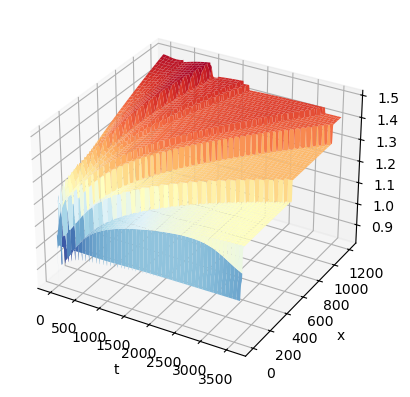

In [69]:
## 画图 ##
t = np.linspace(0, 3600, 1000)
x = np.linspace(0, 1200, 1000)
ms_t, ms_x = np.meshgrid(t, x)
x_np = np.ravel(ms_x).reshape(-1, 1)
t_np = np.ravel(ms_t).reshape(-1, 1)
pt_x = Variable(torch.as_tensor(np.asarray(x_np)).float().to(run_device), requires_grad=True)
pt_t = Variable(torch.as_tensor(np.asarray(t_np)).float().to(run_device), requires_grad=True)
pt_u0 = net(torch.cat([pt_t, pt_x], 1))

h = pt_u0.data.cpu().numpy()
for i,hi in enumerate(h):
    if hi<0:
      h[i]=0

pt_h = h.reshape(1000, 1000)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.set_zlim([1, 10])
ax.plot_surface(ms_t, ms_x, pt_h, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('h')
plt.show()

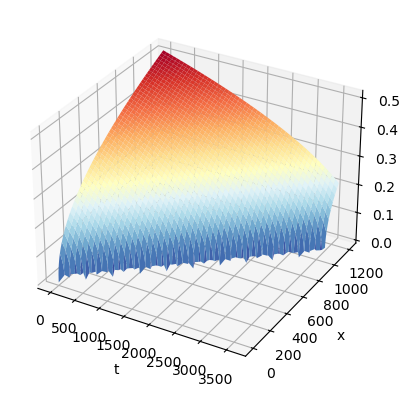

In [70]:


n=0.03
u=0.29

t = np.linspace(0, 3600, 1000)
x = np.linspace(0, 1200, 1000)
ms_t, ms_x = np.meshgrid(t, x)
x_np = np.ravel(ms_x).reshape(-1, 1)
t_np = np.ravel(ms_t).reshape(-1, 1)
pt_x = Variable(torch.as_tensor(np.asarray(x_np)).float().to(run_device), requires_grad=True)
pt_t = Variable(torch.as_tensor(np.asarray(t_np)).float().to(run_device), requires_grad=True)

h=(7/3*(n**2 * u**2 * (pt_x-u*pt_t)))**(3/7)
h = h.data.cpu().numpy()

pt_h = h.reshape(1000, 1000)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.set_zlim([1, 10])
ax.plot_surface(ms_t, ms_x, pt_h, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('h')
plt.show()
